In [1]:
import sys
sys.path.append('/home/token/Documents/distribution_connector')

In [2]:
from sklearn import datasets
import numpy as np
import torch
import torch.nn.functional as F
import time

In [3]:
sys.path

['/home/token/Documents/dnn-mode-connectivity',
 '/home/token/anaconda3/lib/python37.zip',
 '/home/token/anaconda3/lib/python3.7',
 '/home/token/anaconda3/lib/python3.7/lib-dynload',
 '',
 '/home/token/.local/lib/python3.7/site-packages',
 '/home/token/anaconda3/lib/python3.7/site-packages',
 '/home/token/anaconda3/lib/python3.7/site-packages/IPython/extensions',
 '/home/token/.ipython',
 '/home/token/Documents/distribution_connector']

In [4]:
import utils
from connector import Connector
from one_layer_utils import samples, make_dataset, get_model, get_b
from utils import test_model

In [5]:
# # making CIFAR dataset
# import models
# architecture = getattr(models, "LinearOneLayerCF") #LinearOneLayer LogRegression

# dataset, B = make_dataset(model_dir='curves/LinearOneLayer/curve', 
#              dataset='CIFAR', 
#              architecture=architecture, 
#              N_models=21, check=400)

In [6]:
# # making MNIST dataset
# import models
# architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression

# dataset, B = make_dataset(model_dir='curves_mnist/LinearOneLayer/LongTraining/curve', 
#              dataset='MNIST', 
#              architecture=architecture, 
#              N_models=61, check=30)

In [7]:
# dataset.shape, B.shape

In [8]:
# from flows.models.RNVP import RealNVP, RealNVP_OneLayer
# from flows.models.IAF import Flow_IAF
# flow_RNVP = RealNVP(in_dim=795, dim_middle=1000, N_layers=5, batch_norm=True)
# flow_IAF = Flow_IAF(in_dim=795, dim_middle=1000, N_layers=5, batch_norm=True)

# flow_RNVP.load_state_dict(torch.load('/home/anokhin/distribution_connector/flow_models/RealNVP/MNIST/checkpoint-100.pt')['model_state'])
# flow_IAF.load_state_dict(torch.load('/home/anokhin/distribution_connector/flow_models/Flow_IAF/MNIST/checkpoint-100.pt')['model_state'])

# flows = [flow_RNVP, flow_IAF]


In [9]:
import os
def save_checkpoint(dir, epoch, name='checkpoint', **kwargs):
    os.makedirs(dir, exist_ok=True)
    state = {
        'epoch': epoch,
    }
    state.update(kwargs)
    filepath = os.path.join(dir, '%s-%d.pt' % (name, epoch))
    torch.save(state, filepath)

def iterate_minibatches(train_data, batchsize):
    indices = np.random.permutation(np.arange(len(train_data)))
    for start in range(0, len(indices), batchsize):
        ix = indices[start: start + batchsize]
        yield train_data[ix]

results = []
results2 = []

def train(dataset, model, optimizer, epochs=20, batchsize=512, start_epoch=1, save_freq=100,
          scheduler=None, cuda=True, dir=None, test_every=10):
    
    mnist = [(samples(model1)-dataset_mean)/dataset_std, (samples(model2)-dataset_mean)/dataset_std]
    cntr = Connector(*mnist)

    for epoch in range(start_epoch, epochs + 1):
        
        if epoch % test_every == 0:
            model.eval()
            b = get_b(model1, model2)
            print('sampling testing')
#             result2 = test_model(model, loaders, cuda=cuda)
#             results2.append(result2)
            res = model.sample(K=2000).cpu().data.numpy()
            res = dataset_std*res+dataset_mean
            m = get_model(res, b, architecture)
            result2 = test_model(m, loaders)
            results2.append(result2)
            
            print('flow testing')
            model.cuda()
            model.eval()
            res = cntr.flow_connect(model, cuda=True)[1]
            res = dataset_std*res+dataset_mean
            m = get_model(res, b, architecture)
            result = test_model(m, loaders)
            results.append(result)
            
            
        scheduler.step()
        model.train()

        t = time.time()
        total_loss = 0

        for X in iterate_minibatches(dataset, batchsize):
            if cuda:
                X = torch.FloatTensor(X).cuda()
            else:
                X = torch.FloatTensor(X)
            loss = -model.log_prob(X).mean()  # compute the maximum-likelihood loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss

        total_loss /= (len(dataset)/batchsize)
        print('epoch %s:' % epoch, 'loss = %.3f' % total_loss, 'time = %.2f' % (time.time() - t))
        if epoch % save_freq == 0:
            save_checkpoint(
                dir,
                epoch,
                model_state=model.state_dict(),
                optimizer_state=optimizer.state_dict()
            )





In [10]:
def train_true(dataset, model, optimizer, epochs=20, batchsize=512, start_epoch=1, save_freq=100,
          scheduler=None, cuda=True, dir=None, test_every=10):
    
    mnist = [(samples(model1)-dataset_mean)/dataset_std, (samples(model2)-dataset_mean)/dataset_std]
    cntr = Connector(*mnist)

    for epoch in range(start_epoch, epochs + 1):
        
        if epoch % test_every == 0:
            result = test_model(model, loaders, cuda=True)
            model.eval()
            b = get_b(model1, model2)
            print('sampling testing')
#             result2 = test_model(model, loaders, cuda=cuda)
#             results2.append(result2)
            res = model.sample(K=2000).cpu().data.numpy()
#             res = dataset_std*res+dataset_mean
            m = get_model(res, b, architecture)
            result2 = test_model(m, loaders)
            results2.append(result2)        
            
        scheduler.step()
        model.train()

        t = time.time()
        total_loss = 0
        rand = np.random.permutation(np.arange(15))+1
        ind1, ind2 = rand[:2]
        print('indeces', ind1, ind2)
        model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve'+str(ind1)+'/checkpoint-30.pt')['model_state'])
        model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve'+str(ind2)+'/checkpoint-30.pt')['model_state'])
        model.model1 = torch.FloatTensor(samples(model1)).cuda()
        model.model2 = torch.FloatTensor(samples(model2)).cuda()

        train_res = utils.train(loaders['train'], model, optimizer, criterion=F.cross_entropy, regularizer=None, cuda=True)
        print(train_res)
#         train_res = utils.test(loaders['train'], model, criterion=F.cross_entropy, regularizer=None, cuda=True)
#         print(train_res)
        print('train flow loglikelihood')
        print('='*10)
        train(dataset, model, optimizer, epochs=20, batchsize=512, start_epoch=1, save_freq=100,
          scheduler=None, cuda=True, dir=None, test_every=10)
        print('='*20)

        total_loss /= (len(dataset)/batchsize)
        print('time = %.2f' % (time.time() - t))
        if epoch % save_freq == 0:
            save_checkpoint(
                dir,
                epoch,
                model_state=model.state_dict(),
                optimizer_state=optimizer.state_dict()
            )





# Train MNIST

In [25]:
import models
architecture = getattr(models, "LinearOneLayer") #LinearOneLayer LogRegression

model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve10/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve20/checkpoint-30.pt')['model_state'])



import data
loaders, num_classes = data.loaders(
    "MNIST",
    "data",
    128,
    1,
    "VGG",
    True)

mnist = [samples(model1), samples(model2)]

cntr = Connector(*mnist)


You are going to run models on the test set. Are you sure?


/home/token/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


In [26]:
b = get_b(model1, model2)
import pickle
data_path = '/home/token/Documents/dnn-mode-connectivity/data/MNIST.pickle'
with open(data_path, 'rb') as handle:
    dataset, B = pickle.load(handle)
B = np.array(B).mean(0)

# dataset_mean = dataset.mean(0)
# dataset_std = dataset.std(0)
# dataset=(dataset-dataset_mean)/dataset_std

# Training on Crossentropy

In [30]:
from flows.models import Flow_IAF, IAF_OneLayer, IAF_OneLayer_full, RealNVP_OneLayer_full
model = RealNVP_OneLayer_full(in_dim=795, dim_middle=1500, N_layers=3, batch_norm=False, data_b2=b.mean(0))


from torch.optim.lr_scheduler import StepLR
trainable_parametrs = filter(lambda param: param.requires_grad,
                             model.parameters())  # list of all trainable parameters in a flow
trainable_parametrs = model.parameters()
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-5,
                             weight_decay=0)  # choose an optimizer, use module torch.optim

scheduler = StepLR(optimizer, step_size=10, gamma=0.1)



mask len 6


In [31]:
model.cuda()
model.model1 = torch.FloatTensor(samples(model1)).cuda()
model.model2 = torch.FloatTensor(samples(model2)).cuda()


In [ ]:
train_true(dataset, model, optimizer, epochs=2000, batchsize=1024, start_epoch=1, save_freq=10,
          scheduler=scheduler, cuda=True, 
          dir='/home/token/Documents/distribution_connector/flow_models', test_every=10)

indeces 2 1
{'loss': 0.08223863598704338, 'accuracy': 97.90166666666667}
time = 135.54
indeces 3 9
{'loss': 0.06686083235343297, 'accuracy': 98.16833333333334}
time = 136.77
indeces 8 13
{'loss': 0.055984488977988564, 'accuracy': 98.28166666666667}
time = 134.71
indeces 5 13
{'loss': 0.05256961345026891, 'accuracy': 98.335}
time = 133.76
indeces 11 15
{'loss': 0.04974227250417074, 'accuracy': 98.38666666666667}
time = 133.44
indeces 12 14
{'loss': 0.04959185170133908, 'accuracy': 98.41166666666666}
time = 133.44
indeces 13 11
{'loss': 0.046497733121116956, 'accuracy': 98.53833333333333}
time = 133.33
indeces 5 2
{'loss': 0.047000288088123, 'accuracy': 98.51}
time = 133.38
indeces 11 10
{'loss': 0.04444396641254425, 'accuracy': 98.61833333333334}
time = 133.45
train results {'nll': 0.03940325947701931, 'loss': 0.03940325947701931, 'accuracy': 98.77666666666667}
test results {'nll': 0.07774653367996216, 'loss': 0.07774653367996216, 'accuracy': 97.73}
sampling testing
train results {'nll'

In [30]:
model1.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve16/checkpoint-30.pt')['model_state'])
model2.load_state_dict(torch.load('curves_mnist/LinearOneLayer/LongTraining/curve20/checkpoint-30.pt')['model_state'])
model.model1 = torch.FloatTensor(samples(model1)).cuda()
model.model2 = torch.FloatTensor(samples(model2)).cuda()



In [31]:
model.p = 0.5
test_model(model, loaders, cuda=True)

train results {'nll': 0.0524389581600825, 'loss': 0.0524389581600825, 'accuracy': 98.18833333333333}
test results {'nll': 0.0841685208082199, 'loss': 0.0841685208082199, 'accuracy': 97.42}


({'nll': 0.0524389581600825,
  'loss': 0.0524389581600825,
  'accuracy': 98.18833333333333},
 {'nll': 0.0841685208082199, 'loss': 0.0841685208082199, 'accuracy': 97.42})

# training usual flow

In [17]:
# from flows.models.RNVP import RealNVP, RealNVP_OneLayer
# model = RealNVP_OneLayer(in_dim=795, dim_middle=3000, N_layers=2, batch_norm=True, data_b2=b.mean(0))

from flows.models.IAF import Flow_IAF, IAF_OneLayer
model = IAF_OneLayer(in_dim=795, dim_middle=795, N_layers=8, batch_norm=True, data_b2=b.mean(0))


from torch.optim.lr_scheduler import StepLR
trainable_parametrs = filter(lambda param: param.requires_grad,
                             model.parameters())  # list of all trainable parameters in a flow
trainable_parametrs = model.parameters()
optimizer = torch.optim.Adam(trainable_parametrs, lr=1e-3,
                             weight_decay=0)  # choose an optimizer, use module torch.optim

scheduler = StepLR(optimizer, step_size=30, gamma=0.1) 

In [16]:
model.cuda()
train(dataset, model, optimizer, epochs=2000, batchsize=1024, start_epoch=1, save_freq=10,
          scheduler=scheduler, cuda=True, 
          dir='/home/token/Documents/distribution_connector/flow_models', test_every=5)

In [17]:
print('flow testing')
model.cuda()
model.eval()
res = cntr.flow_connect(model, cuda=True)[1]

res = dataset_std*res+dataset_mean
m = get_model(res, b, architecture)
result = test_model(m, loaders)
results.append(result)

flow testing
train results {'nll': nan, 'loss': nan, 'accuracy': 9.871666666666666}
test results {'nll': nan, 'loss': nan, 'accuracy': 9.8}


In [18]:
res = model.sample(K=2000).cpu().data.numpy()
res = dataset_std*res+dataset_mean
m = get_model(res, b, architecture)
result2 = test_model(m, loaders)

train results {'nll': 2.613150601323446, 'loss': 2.613150601323446, 'accuracy': 8.786666666666667}
test results {'nll': 2.630157893371582, 'loss': 2.630157893371582, 'accuracy': 8.6}


In [ ]:
results2

In [50]:
len(results)

0

In [51]:
len(results2)

0

In [17]:
results2

[({'nll': 2.308320469526811, 'loss': 2.308320469526811, 'accuracy': 9.8},
  {'nll': 2.306293741226196, 'loss': 2.306293741226196, 'accuracy': 10.22}),
 ({'nll': 2.453471098258279,
   'loss': 2.453471098258279,
   'accuracy': 7.683636363636364},
  {'nll': 2.4490622764587404, 'loss': 2.4490622764587404, 'accuracy': 7.84}),
 ({'nll': 2.3947739324743096,
   'loss': 2.3947739324743096,
   'accuracy': 8.314545454545454},
  {'nll': 2.387903778076172, 'loss': 2.387903778076172, 'accuracy': 8.64}),
 ({'nll': 2.350362539256703,
   'loss': 2.350362539256703,
   'accuracy': 9.023636363636363},
  {'nll': 2.3466534309387206, 'loss': 2.3466534309387206, 'accuracy': 9.16}),
 ({'nll': 2.3957559408014473,
   'loss': 2.3957559408014473,
   'accuracy': 10.181818181818182},
  {'nll': 2.3925726051330565, 'loss': 2.3925726051330565, 'accuracy': 10.76}),
 ({'nll': 2.3671703203374688,
   'loss': 2.3671703203374688,
   'accuracy': 10.790909090909091},
  {'nll': 2.359107334518433, 'loss': 2.359107334518433, 'acc

# Train CIFAR

In [10]:
from flows.models.RNVP import RealNVP
from flows.models.IAF import Flow_IAF
flow_RNVP = RealNVP(in_dim=3083, dim_middle=1000, N_layers=5, batch_norm=True)
flow_IAF = Flow_IAF(in_dim=3083, dim_middle=1000, N_layers=5, batch_norm=True)

flow_RNVP.load_state_dict(torch.load('/home/anokhin/distribution_connector/flow_models/RealNVP/CIFAR/checkpoint-100.pt')['model_state'])
flow_IAF.load_state_dict(torch.load('/home/anokhin/distribution_connector/flow_models/Flow_IAF/CIFAR/checkpoint-100.pt')['model_state'])

flows = [flow_RNVP, flow_IAF]


mask len 10


In [11]:
import models
architecture = getattr(models, "LinearOneLayerCF") #LinearOneLayer LogRegression

model1 = architecture.base(num_classes=10, **architecture.kwargs)
model2 = architecture.base(num_classes=10, **architecture.kwargs)

model1.load_state_dict(torch.load('curves/LinearOneLayer/curve1/checkpoint-400.pt')['model_state'])
model2.load_state_dict(torch.load('curves/LinearOneLayer/curve2/checkpoint-400.pt')['model_state'])

cifar = [samples(model1), samples(model2)]
test_datasets = [cifar]

import data
loaders, num_classes = data.loaders(
    "CIFAR10",
    "data",
    512,
    1,
    "VGG",
    False)

Files already downloaded and verified
Using train (45000) + validation (5000)
len 45000
Files already downloaded and verified


In [12]:
cntr = Connector(*cifar)

In [18]:
b = get_b(model1, model2)
import pickle
data_path = '/home/anokhin/dnn-mode-connectivity/data/CIFAR.pickle'
with open(data_path, 'rb') as handle:
    dataset, B = pickle.load(handle)
B = np.array(B).mean(0)

In [23]:
model = RealNVP_OneLayer(in_dim=3083, dim_middle=3000, N_layers=2, batch_norm=True, data_b2=b.mean(0))
from torch.optim.lr_scheduler import StepLR
trainable_parametrs = filter(lambda param: param.requires_grad,
                             model.parameters())  # list of all trainable parameters in a flow
trainable_parametrs = model.parameters()
optimizer = torch.optim.SGD(trainable_parametrs, lr=1e-4,
                             weight_decay=1e-4)  # choose an optimizer, use module torch.optim

scheduler = StepLR(optimizer, step_size=5, gamma=0.9) 

mask len 4


In [24]:
import time
model.cuda()
train(dataset, model, optimizer, epochs=20, batchsize=128, start_epoch=1, save_freq=100,
          scheduler=scheduler, cuda=True, dir=None, test='model')

epoch 1: loss = -9167.361 time = 18.57
flow testing
train results {'nll': 2.891166934797499, 'loss': 2.891166934797499, 'accuracy': 31.4}
test results {'nll': 5.726604048919678, 'loss': 5.726604048919678, 'accuracy': 25.26}
epoch 2: loss = -10111.746 time = 18.59
flow testing
train results {'nll': 2.57101685057746, 'loss': 2.57101685057746, 'accuracy': 33.70666666666666}
test results {'nll': 4.805510887145996, 'loss': 4.805510887145996, 'accuracy': 27.68}
epoch 3: loss = -10416.328 time = 18.58
flow testing
train results {'nll': 2.4487291524675157, 'loss': 2.4487291524675157, 'accuracy': 34.33555555555556}
test results {'nll': 4.694885636901856, 'loss': 4.694885636901856, 'accuracy': 28.28}
epoch 4: loss = -10584.841 time = 18.59
flow testing
train results {'nll': 2.402907786093818, 'loss': 2.402907786093818, 'accuracy': 34.708888888888886}
test results {'nll': 4.667445269012451, 'loss': 4.667445269012451, 'accuracy': 28.36}
epoch 5: loss = -10701.868 time = 18.61
flow testing
train re

KeyboardInterrupt: 

In [7]:
# for noisy_normal in noisy_normals:
#     noisy_normal[:, 0] -= 0.5*noisy_normal[:, 1]*noisy_normal[:, 1]
#     first = (np.diag(third_cumulants[n1])*(1-a-b)).sum(0)

In [9]:
# cntr = Connector(*noisy_normals)

In [10]:
# th_c = cntr.compute_3cumulant(noisy_normals[0])

In [11]:
# delta1 = cntr.compute_flow_delta(th_c, noisy_normals[0])
# delta2 = cntr.compute_flow_delta(th_c, noisy_normals[1])

In [12]:
# delta.shape, noisy_normals[0].shape

In [13]:
# cntr.show_samples(noisy_normals, show='points', limits=False)

In [14]:
# noisy_normals_3 = []
# noisy_normals_3.append(noisy_normals[0]+delta1)
# noisy_normals_3.append(noisy_normals[1]+delta2)

In [15]:
# cntr.show_samples(noisy_normals_3, show='points', limits=False)

In [16]:
# noisy_normals[0].mean(0), noisy_normals[1].mean(0)

In [17]:
# print(noisy_normals[0].T@noisy_normals[0]/1000)
# print(noisy_normals[1].T@noisy_normals[1]/1000)

In [18]:
# noisy_normals_3[0].mean(0), noisy_normals_3[1].mean(0)

In [19]:
# print(noisy_normals_3[0].T@noisy_normals_3[0]/1000)
# print(noisy_normals_3[1].T@noisy_normals_3[1]/1000)

In [20]:
# th_c

In [21]:
# cntr.compute_3cumulant(noisy_normals_3[0])

In [22]:
# cntr.compute_3cumulant(noisy_normals_3[1])

In [23]:
# test_datasets = [noisy_normals_3]

In [24]:
# res = cntr.arc_connect()
# cntr.show_samples(res, show='points', limits=False)

In [25]:
# cntrs = []
# results = []
# for test in test_datasets:
#     cntr = Connector(*test)
#     cntrs.append(cntr)
#     res = cntr.arc_connect()
#     results.append(res)
#     cntr.show_samples(res, show='points', limits=False)


In [26]:
# cntr.compute_3cumulant()

arc_connect


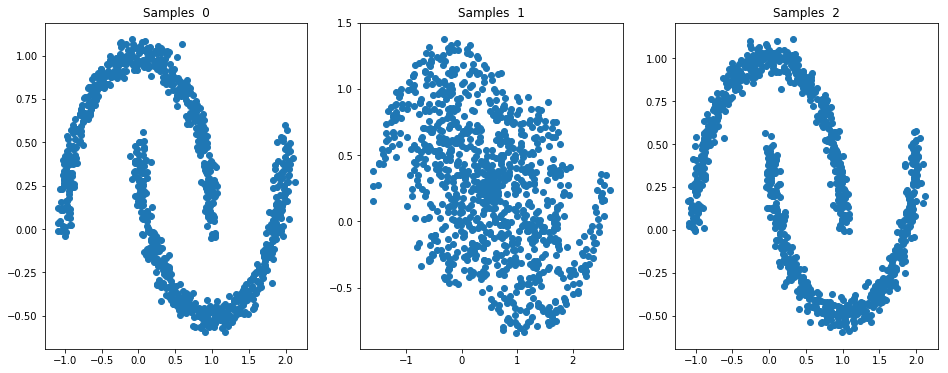

flow_connect
(2000, 2)


ValueError: expected 2D or 3D input (got 1D input)

In [27]:
for test in test_datasets:
    cntr = Connector(*test)
    for f in [func for func in dir(cntr) if callable(getattr(cntr, func)) and 'connect' in func]:
        func = getattr(cntr, f)
        print(func.__name__)
        if func.__name__=='flow_connect':
            res = func(flow)
        else:
            res = func()
        cntr.show_samples(res, show='points', limits=False)